## Analysis of the Perception of 4 Companies Through Tweets and Automatic Sentiment Prediction
### <center> **Directed by Elauïne BERNARD**
### <center> Statistician, Econometrician / Data Scientist

###  **PLAN**
1. **Context**
2. **Objectives**
3. **Data Import and Processing**
4. **Exploratory Data Analysis**
5. **Feature Egineering**
6. **Modelization**
7. **Example of using**

#### 1- **Context**
With the rise of social media, particularly Twitter, users share their opinions and perceptions about companies in real-time, thereby influencing their public image. Analyzing these tweets allows for a better understanding of user perceptions and automatic prediction of expressed sentiments, which is crucial for companies looking to adjust their communication strategies and manage their online reputation.

#### 2- **Objectives**
- Analyze tweets to understand user perceptions of four companies: Google, Amazon, Facebook, and Microsoft.
- Develop a machine learning model capable of automatically predicting the sentiment (positive, neutral, negative) of tweets without human reading.

#### Importing packages

In [257]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

#### 3- Data Import and Processing

In [41]:
# Work directory definition
new_directory = r"C:\Users\berna\Documents\Portfolio\data"
os.chdir(new_directory)

In [62]:
# Source: The dataset was loaded locally from the Kaggle site (https://www.kaggle.com/)
#1.1- Import data
Base=pd.read_csv("Tweet_data2.csv")
# View of first rows
Base.head()

,Twit_ID,Entity,Sentiment,Tweet_content
0,1,Amazon,Negative,@amazon wtf .
1,1,Amazon,Negative,@ amazon wtf.
2,1,Amazon,Negative,@ amazon wtf.
3,1,Amazon,Negative,@amazon wtf?
4,1,Amazon,Negative,7 @amazon wtf.


In [48]:
#1.2- basic information
Base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7806 entries, 0 to 7805
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Twit_ID        7806 non-null   int64 
 1   Entity         7806 non-null   object
 2   Sentiment      7806 non-null   object
 3   Tweet_content  7716 non-null   object
dtypes: int64(1), object(3)
memory usage: 244.1+ KB


The dataset has 7806 rows and 4 variables
- Twit_ID: Unique identifier for each tweet.
- Entity: Name of the company the tweet is addressed to (among Google, Amazon, Facebook, and Microsoft).
- Sentiment: Sentiment expressed in the tweet (positive, neutral, or negative).
- Tweet_content: Content of the tweet.
    
All variables have been defined in the correct type

In [64]:
#1.3- Duplicate checking
# Count the number of duplicated 
duplicated_rows=Base.duplicated().sum()
print("Before, they were ", duplicated_rows, " duplicated rows.")

# drop duplicated
Base.drop_duplicates(inplace=True)

# last check
duplicated_rows=Base.duplicated().sum()
print("After, they are ", duplicated_rows, " duplicated rows.")
print("Now, dataset has ", len(Base), " rows.")

Before, they were  258  duplicated rows.
After, they are  0  duplicated rows.
Now, dataset has  7548  rows.


In [74]:
#1.4- Management of missing values
#Displaying variables with missing values
missing_values=Base.isna().sum()
missing_values=missing_values[missing_values>0]
print("Before, they were", len(missing_values), "variable(s) with missing values :")
print(missing_values)

#Drop rows with missing values
Base.dropna(inplace=True)

# Last check
missing_values=Base.isna().sum()
missing_values=missing_values[missing_values>0]
print("Now, they are", len(missing_values), "variable(s) with missing values :")
print("Now, dataset has ", len(Base), " rows.")

Before, they were 1 variable(s) with missing values :
Tweet_content    36
dtype: int64
Now, they are 0 variable(s) with missing values :
Now, dataset has  7512  rows.


#### 4- **Exploratory Data Analysis**

##### 4.1- Distribution of sentiments

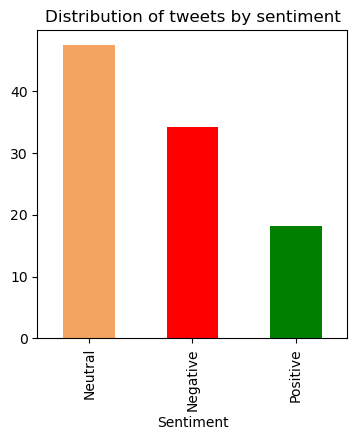

In [132]:
colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'sandybrown'}
distribution_sentiment=(Base["Sentiment"].value_counts(normalize=True))*100
plt.figure(figsize=(4, 4))
plt.title('Distribution of tweets by sentiment')
distribution_sentiment.plot(kind="bar", color=[colors[sentiment] for sentiment in distribution_sentiment.index])
plt.show()

- Neutral sentiment (47.5%): Almost half of the tweets express a neutral sentiment, indicating that many users share opinions that are factual or without strong emotional engagement.
- Negative sentiment (34.2%): A significant portion of the tweets is negative, representing over a third, which suggests considerable criticism or dissatisfaction toward the companies.
- Positive sentiment (18.2%): Positive tweets make up the smallest proportion, implying that favorable opinions are shared less frequently than neutral or negative ones

##### 4.2- Distribution of companies

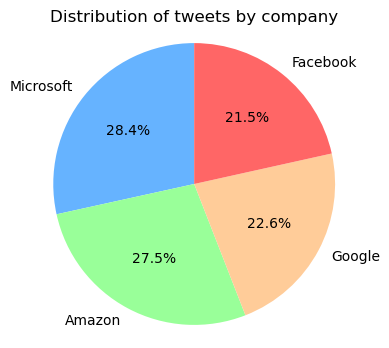

In [103]:
distribution_entity=Base["Entity"].value_counts(normalize=True)
plt.figure(figsize=(4, 4))
plt.pie(distribution_entity, labels=distribution_entity.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99', '#ffcc99', '#ff6666'])
plt.title('Distribution of tweets by company')
plt.axis('equal') 
plt.show()

- Microsoft (28.4%): Microsoft accounts for the largest proportion of tweets, indicating that it generates the most discussions among users.
- Amazon (27.5%): Amazon closely follows, with almost as many tweets as Microsoft, showing its strong presence in user conversations.
- Google (22.6%): Google represents a smaller share of the tweets compared to Microsoft and Amazon, but still maintains a significant level of engagement.
- Facebook (21.5%): Facebook has the smallest proportion of tweets, suggesting relatively fewer discussions about the company compared to the others.

##### 4.3-Breakdown of feelings by company

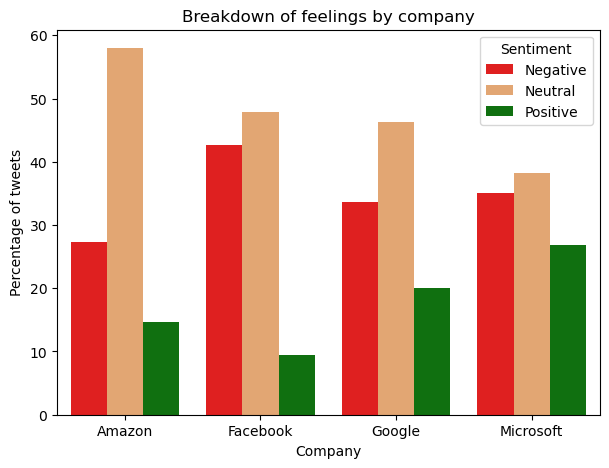

In [239]:
cross_tab = (pd.crosstab(Base['Entity'], Base['Sentiment'],normalize='index'))*100
cross_tab_long = cross_tab.reset_index().melt(id_vars='Entity', var_name='Sentiment', value_name='Count')

plt.figure(figsize=(7, 5))
sns.barplot(data=cross_tab_long, x='Entity', y='Count', hue='Sentiment',
            palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'sandybrown'})  

plt.title('Breakdown of feelings by company')
plt.xlabel('Company')
plt.ylabel('Percentage of tweets')
plt.legend(title='Sentiment')

plt.show()

- 58 % of tweets on Amazon are neutral, while 27% are negative and 14% are positive.
- 48 % of tweets on Facebook are neutral, with 42% negative and only 10 % positive.
- 46 % of tweets on Google are neutral, while 34 % are negative and 20 % are positive.
- 38 % of tweets on Microsoft are neutral, with 35% negative and 27% positive.

##### 4.4- Chi-square test

In [141]:
chi2, p, dof, expected = chi2_contingency(cross_tab)
if p < 0.05:
    print("There is a significant relationship between companies and feelings (reject H0).")
else:
    print("There is no significant relationship between companies and feelings (H0 is not rejected).")

There is a significant relationship between companies and feelings (reject H0).


The test shows that the sentiments expressed in the tweets are not company-independent. In other words, certain companies are more associated with certain types of sentiment (positive, negative or neutral).

The results show that the distribution of sentiments varies significantly across companies, with Amazon and Facebook mostly associated with neutral or negative sentiments, while Microsoft and Google are viewed more favorably with higher proportions of positive sentiments. The chi-square test confirms that the sentiments expressed are not independent of the companies. This indicates a clear difference in user perception depending on the company.

#### 5- Feature Engineering

##### 5.1- Cleaning tweet content

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
# 5.1.1-  Remove unwanted characters

# Initialize  lemmatizer
lemmatizer = WordNetLemmatizer()

# Function for cleaning up and transforming tweets
def preprocess_tweet(tweet):
    #Remove URLs, mentions (@), hashtags, emojis, and punctuation.
    tweet = re.sub(r"http\S+|www\S+|@\S+|#\S+", "", tweet)
    tweet = re.sub(r"[^\w\s]", "", tweet)  #  Remove punctuation
    # Tokenize
    tokens = word_tokenize(tweet)
    # Remove stopwords and lemmatize words
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stopwords.words('english')]
    return " ".join(tokens)

# Apply cleanup to tweets column
Base['Cleaned_Tweet'] = Base['Tweet_content'].apply(preprocess_tweet)

Base.head(3)

##### 5.2- Transforming tweet content into numeric data 

In [181]:
# Initialize vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit most frequent words to 5000
X = tfidf_vectorizer.fit_transform(Base['Cleaned_Tweet'])

##### 5.3- Encoding

In [193]:
# 5.3.1-One-hot-encoding for "Entity' column
Base_encoded = pd.get_dummies(Base, columns=['Entity'])
Base_encoded.head(2)

,Twit_ID,Sentiment,Tweet_content,Cleaned_Tweet,Entity_Amazon,Entity_Facebook,Entity_Google,Entity_Microsoft
0,1,Negative,@amazon wtf .,wtf,True,False,False,False
1,1,Negative,@ amazon wtf.,amazon wtf,True,False,False,False


In [201]:
# 5.3.2- Encoding target variable
le = LabelEncoder()
Base['Sentiment_Encoded'] = le.fit_transform(Base['Sentiment'])
Base.head(2)

,Twit_ID,Entity,Sentiment,Tweet_content,Cleaned_Tweet,Sentiment_Encoded
0,1,Amazon,Negative,@amazon wtf .,wtf,0
1,1,Amazon,Negative,@ amazon wtf.,amazon wtf,0


##### 5.4-Split data

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X,Base['Sentiment_Encoded'], test_size=0.2, random_state=42)

#### 6- Modelization

##### 6.1-Using the gridsearch method to select hyperparameters

In [233]:
# Logistic regression
log_reg_param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
log_reg = GridSearchCV(LogisticRegression(max_iter=1000), log_reg_param_grid, cv=5, verbose=2)
log_reg.fit(X_train, y_train)

# Random Forest
rf_param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]}
rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, verbose=2)
rf.fit(X_train, y_train)

# SVM
svm_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
svm = GridSearchCV(SVC(), svm_param_grid, cv=5, verbose=2)
svm.fit(X_train, y_train)

# K-Nearest Neighbors
knn_param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
knn = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, verbose=2)
knn.fit(X_train, y_train)

# Naive Bayes
nb_param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}
nb = GridSearchCV(MultinomialNB(), nb_param_grid, cv=5, verbose=2)
nb.fit(X_train, y_train)

# The best hyperparameters
print("Meilleur modèle Régression Logistique : ", log_reg.best_params_)
print("Meilleur modèle Random Forest : ", rf.best_params_)
print("Meilleur modèle SVM : ", svm.best_params_)
print("Meilleur modèle KNN : ", knn.best_params_)
print("Meilleur modèle Naive Bayes : ", nb.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END .............................................C=0.01; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.0s
[CV] END ........................................

##### 6.2- Model training with gridsearch's best hyparameters

In [249]:
# Initializing
log_reg_best = LogisticRegression(C=100, max_iter=1000)
rf_best = RandomForestClassifier(max_depth=None, n_estimators=300, random_state=42)
svm_best = SVC(C=10, gamma=1,random_state=42)
knn_best = KNeighborsClassifier(n_neighbors=3, weights='distance')
nb_best = MultinomialNB(alpha=0.1)

# Training
log_reg_best.fit(X_train, y_train)
rf_best.fit(X_train, y_train)
svm_best.fit(X_train, y_train)
knn_best.fit(X_train, y_train)
nb_best.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

##### 6.3-Model testing

In [241]:
models = {
    'Logistic Regression': log_reg_best, 
    'Random Forest': rf_best, 
    'SVM': svm_best, 
    'KNN': knn_best,
    'Naive Bayes': nb_best
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n{name} - Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


Logistic Regression - Accuracy: 0.9414504324683965
              precision    recall  f1-score   support

    Negative       0.95      0.93      0.94       501
     Neutral       0.93      0.97      0.95       726
    Positive       0.96      0.88      0.92       276

    accuracy                           0.94      1503
   macro avg       0.95      0.93      0.94      1503
weighted avg       0.94      0.94      0.94      1503


Random Forest - Accuracy: 0.9387890884896873
              precision    recall  f1-score   support

    Negative       0.95      0.91      0.93       501
     Neutral       0.91      0.99      0.95       726
    Positive       1.00      0.86      0.92       276

    accuracy                           0.94      1503
   macro avg       0.95      0.92      0.93      1503
weighted avg       0.94      0.94      0.94      1503


SVM - Accuracy: 0.957418496340652
              precision    recall  f1-score   support

    Negative       0.98      0.94      0.96       

SVM clearly stands out as the best-performing model, with high accuracy (95.7%) and a very good balance between precision and recall for all classes. We therefore choose it. 

#### 7- Examples of using

##### 7.1- Creating function
We create a function to automatically handle everything, so the user just enters a comment, and the function returns the predicted sentiment

In [264]:
# Define the function to predict the sentiment
def predict_sentiment():
    while True:
        # Step 1: Ask the user to input a comment
        comment = input("Enter a comment to analyze (or type 'exit' to quit): ")

        # Exit condition
        if comment.lower() == 'exit':
            print("Exiting the sentiment analysis. Goodbye!")
            break
        
        # Step 2: Preprocess the comment (using preprocess_tweet function)
        cleaned_comment = preprocess_tweet(comment)
        
        # Step 3: Vectorize the comment using the trained TF-IDF vectorizer
        X_comment = tfidf_vectorizer.transform([cleaned_comment])
        
        # Step 4: Predict the sentiment using the pre-trained SVM model
        predicted_sentiment = svm_best.predict(X_comment)[0]
        
        # Step 5: Map the predicted label to the sentiment name
        sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        predicted_label = sentiment_labels[predicted_sentiment]
        
        # Step 6: Display the predicted sentiment
        print(f"Predicted Sentiment: {predicted_label}\n")


##### 7.2- Using the function

In [269]:
# calling the function
predict_sentiment()

Enter a comment to analyze (or type 'exit' to quit):  I love how Amazon delivers my orders so fast. It's always a positive experience!


Predicted Sentiment: Positive



Enter a comment to analyze (or type 'exit' to quit):  Facebook's constant ads are so annoying. It's really ruining the user experience.


Predicted Sentiment: Negative



Enter a comment to analyze (or type 'exit' to quit):  exit


Exiting the sentiment analysis. Goodbye!
